In [81]:
# creative prompts

creative_prompts = ["Write a poem", "Tell me a joke", "Describe the feeling of love", "Write a story starting with 'Once upon a time...'",
                    "Tell a story about a dog", "Write a song", "Write a poem about a robot", "Invent an original recipe",
                    "Imagine a new object and describe what it looks like", "Imagine a new philosophy and describe it"]

# factual prompts
factual_prompts = ["What is the capital of France?", "How is H2O commonly known?", "What is the largest country in the world?", "How many days are in a year?",
                   "What is the largest planet in the solar system?", "What is the largest animal in the world?", "How do you say hello in Spanish?", "Who won the 2018 World Cup?",
                   "What is the biggest city in Europe?", "What is the largest country in Africa?"]





In [150]:
from nltk.translate.bleu_score import sentence_bleu
#TODO check that it matches fairseq self-BLEU
def self_BLEU(sentences, split_sentences=False):
    if split_sentences:
        sentences = [sentence.split() for sentence in sentences]
    scores = []
    for i in range(len(sentences)):
        score = sentence_bleu(sentences[:i] + sentences[i+1:], sentences[i])
        scores.append(score)
    return np.mean(scores)

In [151]:
def format_prompt_llama2(prompt):
    prompt_format = """<s>[INST] <<SYS>>
    You are a helpful, respectful and honest assistant. Always answer without asking questions or clarifications.
    <</SYS>>

    {} [/INST]"""
    return prompt_format.format(prompt)

def format_prompt_vicuna(prompt, version="1.5"):
    model_path = "lmsys/vicuna-7b-v" + version
    conv = get_conversation_template(model_path)
    conv.append_message(conv.roles[0], prompt)
    conv.append_message(conv.roles[1], None)
    full_prompt = conv.get_prompt()
    return full_prompt

#prompt = prompt_format.format("What is the best way to get to the airport?")
#input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
#output_ids = model.generate(input_ids, max_length=300, pad_token_id=tokenizer.eos_token_id, do_sample=True, temperature=1.2, num_return_sequences=2)

#print(tokenizer.decode(output_ids[0], skip_special_tokens=True))


In [157]:
# Use submitit to run this script on a cluster

import submitit
import os
from fastchat.model import get_conversation_template

import numpy as np

# each temperature and for each prompt, generate n_generations samples
temperatures = [k / 10. for k in range(1, 16)]
print(temperatures)
models = ["llama2-chat", "vicuna1.5"]
n_generations = 25
bleu_scores_creative = np.zeros((len(temperatures), len(creative_prompts), len(models)))
bleu_scores_factual = np.zeros((len(temperatures), len(factual_prompts), len(models)))


# define the function to be submitted
def generate_samples(args):
    max_return_sequences = 5 #for memory reasons, we generate the samples in batches of 5
    i, prompt, temperatures, model_name = args
    if model_name == "llama2-chat":
        tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
        model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
        full_prompt = format_prompt_llama2(prompt)
    elif model_name == "vicuna1.5":
        model_path = "lmsys/vicuna-7b-v1.5"
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForCausalLM.from_pretrained(model_path)
        #adapted from https://github.com/lm-sys/FastChat/blob/a47b8f9e93c8b5a85e81d1ae33e3a1106d8cdf80/fastchat/serve/huggingface_api.py
        full_prompt = format_prompt_vicuna(prompt)
    model.to("cuda:0")
    input_ids = tokenizer.encode(full_prompt, return_tensors="pt").to("cuda:0")
    bleu_scores = []
    for temperature in temperatures:
        samples = []
        for _ in range(n_generations // max_return_sequences):
            samples.extend(model.generate(input_ids, temperature=temperature, max_length=input_ids.shape[1] + 50,
                                            num_return_sequences=max_return_sequences, do_sample=True))
        # remove prompt from the samples
        samples = [sample[input_ids.shape[1]:] for sample in samples]
        samples = [tokenizer.decode(sample, skip_special_tokens=True) for sample in samples]
        print(f"Model: {model_name}")
        print(f"Prompt: {prompt}")
        print(f"Temperature: {temperature}")
        print(f"Samples: {samples}")
        bleu_score = self_BLEU(samples, split_sentences=True)
        print(f"BLEU score: {bleu_score}")
        bleu_scores.append(bleu_score)
    return bleu_scores

# create a folder for the logs of the submitted jobs
os.makedirs("logs", exist_ok=True)


for model in models:
    # create a submitit executor
    executor = submitit.AutoExecutor(folder="logs")

    # specify the parameters for the Slurm job
    #exclude margpu002 and margpu003
    executor.update_parameters(timeout_min=60, slurm_partition="parietal,gpu,normal", gpus_per_node=1,
                                # exclude nodes
                                exclude="margpu002,margpu003")
    
    # For creative prompts
    args_list_creative = [(i, prompt, temperatures, model) for i, prompt in enumerate(creative_prompts)]
    jobs_creative = executor.map_array(generate_samples, args_list_creative)

    # For factual prompts
    args_list_factual = [(i, prompt, temperatures, model) for i, prompt in enumerate(factual_prompts)]
    jobs_factual = executor.map_array(generate_samples, args_list_factual)

    # Collect the results for creative prompts
    for i, job in enumerate(jobs_creative):
        bleu_scores = job.result()
        for t_index, score in enumerate(bleu_scores):
            bleu_scores_creative[t_index, i, models.index(model)] = score

    # Collect the results for factual prompts
    for i, job in enumerate(jobs_factual):
        bleu_scores = job.result()
        for t_index, score in enumerate(bleu_scores):
            bleu_scores_factual[t_index, i, models.index(model)] = score

# Save the results
np.save("bleu_scores_creative_max_length50_words.npy", bleu_scores_creative)
np.save("bleu_scores_factual_max_length50_words.npy", bleu_scores_factual)



/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/submitit/auto/auto.py:23: UserWarning: Setting 'exclude' is deprecated. Use 'slurm_exclude' instead.
  warnings.warn(f"Setting '{arg}' is deprecated. Use '{new_arg}' instead.")
sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-09 09:55:36,131) - Call #450 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', 

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
submitit WARNING (2023-08-09 09:55:36,131) - Call #450 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704',

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-09 09:55:38,144) - Call #451 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', '1334447', '-j', 

submitit WARNING (2023-08-09 09:55:38,144) - Call #451 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-09 09:55:41,158) - Call #452 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', '1334447', '-j', 

submitit WARNING (2023-08-09 09:55:41,158) - Call #452 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-09 09:55:47,183) - Call #453 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', '1334447', '-j', 

submitit WARNING (2023-08-09 09:55:47,183) - Call #453 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-09 09:55:59,217) - Call #454 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', '1334447', '-j', 

submitit WARNING (2023-08-09 09:55:59,217) - Call #454 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-09 09:56:22,450) - Call #455 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', '1334447', '-j', 

submitit WARNING (2023-08-09 09:56:22,450) - Call #455 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-09 09:57:09,560) - Call #456 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', '1334447', '-j', 

submitit WARNING (2023-08-09 09:57:09,560) - Call #456 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-09 09:58:43,769) - Call #457 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', '1334447', '-j', 

submitit WARNING (2023-08-09 09:58:43,769) - Call #457 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-09 10:01:52,200) - Call #458 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', '1334447', '-j', 

submitit WARNING (2023-08-09 10:01:52,200) - Call #458 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '

/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/submitit/auto/auto.py:23: UserWarning: Setting 'exclude' is deprecated. Use 'slurm_exclude' instead.
  warnings.warn(f"Setting '{arg}' is deprecated. Use '{new_arg}' instead.")
sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-09 10:06:43,897) - Call #459 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1338155', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', 

submitit WARNING (2023-08-09 10:06:43,897) - Call #459 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1338155', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1338156', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-09 10:06:45,910) - Call #460 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1338155', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', 

submitit WARNING (2023-08-09 10:06:45,910) - Call #460 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1338155', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1338156', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-09 10:06:48,925) - Call #461 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1338155', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', 

submitit WARNING (2023-08-09 10:06:48,925) - Call #461 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1338155', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1338156', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-09 10:06:54,947) - Call #462 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1338155', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', 

submitit WARNING (2023-08-09 10:06:54,947) - Call #462 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1338155', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1338156', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-09 10:07:06,981) - Call #463 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1338155', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', 

submitit WARNING (2023-08-09 10:07:06,981) - Call #463 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1338155', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1338156', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-09 10:07:31,046) - Call #464 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1338155', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', 

submitit WARNING (2023-08-09 10:07:31,046) - Call #464 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1338155', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1338156', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-09 10:08:19,162) - Call #465 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1338155', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', 

submitit WARNING (2023-08-09 10:08:19,162) - Call #465 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1338155', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1338156', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-09 10:09:55,378) - Call #466 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1338155', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', 

submitit WARNING (2023-08-09 10:09:55,378) - Call #466 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1338155', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1338156', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-09 10:13:07,824) - Call #467 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1338155', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', 

submitit WARNING (2023-08-09 10:13:07,824) - Call #467 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1337699', '-j', '1336770', '-j', '1336703', '-j', '1336830', '-j', '1335613', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1338155', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1337724', '-j', '1338135', '-j', '1337689', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1336905', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1338134', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1338156', '-j', '

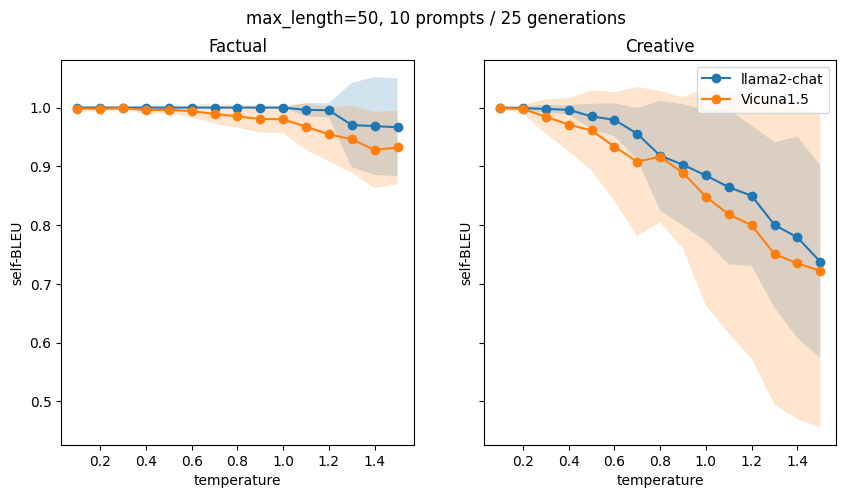

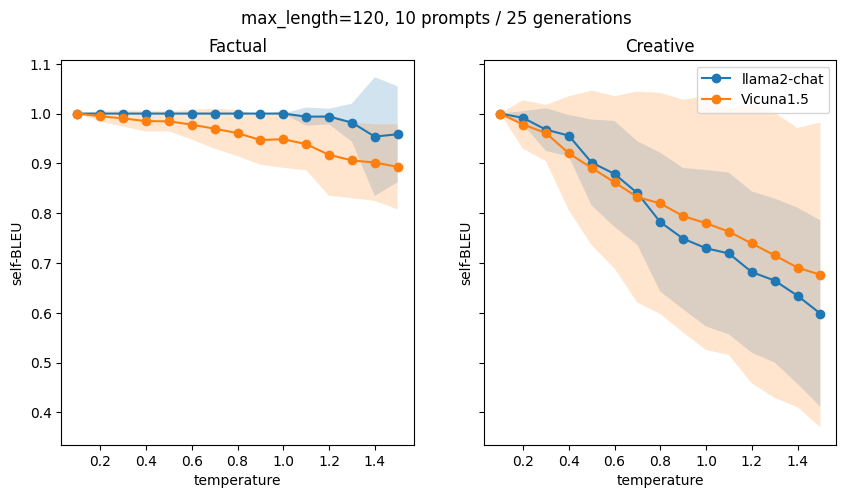

In [160]:
# make two subplots for factual and creative
#bleu_scores_factual = np.load('bleu_scores_factual_max_length50.npy')
#bleu_scores_creative = np.load('bleu_scores_creative_max_length50.npy')
for max_length in [50, 120]:
    bleu_scores_factual = np.load(f'bleu_scores_factual_max_length{max_length}_words.npy')
    bleu_scores_creative = np.load(f'bleu_scores_creative_max_length{max_length}_words.npy')

    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

    # factual
    ax[0].plot(temperatures, bleu_scores_factual[:, :, 0].mean(axis=1), label='llama2-chat', marker='o')
    ax[0].plot(temperatures, bleu_scores_factual[:, :, 1].mean(axis=1), label='Vicuna1.5', marker='o')
    # ribbons with the same color as the lines
    ax[0].fill_between(temperatures, bleu_scores_factual[:, :, 0].mean(axis=1) - bleu_scores_factual[:, :, 0].std(axis=1), bleu_scores_factual[:, :, 0].mean(axis=1) + bleu_scores_factual[:, :, 0].std(axis=1), alpha=0.2)
    ax[0].fill_between(temperatures, bleu_scores_factual[:, :, 1].mean(axis=1) - bleu_scores_factual[:, :, 1].std(axis=1), bleu_scores_factual[:, :, 1].mean(axis=1) + bleu_scores_factual[:, :, 1].std(axis=1), alpha=0.2)

    ax[0].set_title('Factual')
    ax[0].set_xlabel('temperature')
    ax[0].set_ylabel('self-BLEU')

    # creative
    ax[1].plot(temperatures, bleu_scores_creative[:, :, 0].mean(axis=1), label='llama2-chat', marker='o')
    ax[1].plot(temperatures, bleu_scores_creative[:, :, 1].mean(axis=1), label='Vicuna1.5', marker='o')
    # ribbons with the same color as the lines
    ax[1].fill_between(temperatures, bleu_scores_creative[:, :, 0].mean(axis=1) - bleu_scores_creative[:, :, 0].std(axis=1), bleu_scores_creative[:, :, 0].mean(axis=1) + bleu_scores_creative[:, :, 0].std(axis=1), alpha=0.2)
    ax[1].fill_between(temperatures, bleu_scores_creative[:, :, 1].mean(axis=1) - bleu_scores_creative[:, :, 1].std(axis=1), bleu_scores_creative[:, :, 1].mean(axis=1) + bleu_scores_creative[:, :, 1].std(axis=1), alpha=0.2)

    ax[1].set_title('Creative')
    ax[1].set_xlabel('temperature')
    ax[1].set_ylabel('self-BLEU')
    # global title
    fig.suptitle(f'max_length={max_length}, 10 prompts / 25 generations')
    plt.legend()

In [ ]:
def generate_one_sample(prompt, model, temperature):
    if model == "llama2-chat":
        tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
        model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
        full_prompt = format_prompt_llama2(prompt)
    elif model == "vicuna1.5":
        model_path = "lmsys/vicuna-7b-v1.5"
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForCausalLM.from_pretrained(model_path)
        #adapted from https://github.com/lm-sys/FastChat/blob/a47b8f9e93c8b5a85e81d1ae33e3a1106d8cdf80/fastchat/serve/huggingface_api.py
        full_prompt = format_prompt_vicuna(prompt)
    model.to("cuda:0")
    input_ids = tokenizer.encode(full_prompt, return_tensors="pt").to("cuda:0")
    output = model.generate(
        input_ids,
        do_sample=True,
        num_return_sequences=5,
        max_length=150,
        temperature=temperature,
    )
    return prompt, tokenizer.batch_decode(output, skip_special_tokens=True)

# launch with submitit
executor = submitit.AutoExecutor(folder="logs")
executor.update_parameters(timeout_min=60, slurm_partition="parietal,gpu,normal", gpus_per_node=1,
                            # exclude nodes
                            exclude="margpu002,margpu003")
job = executor.submit(generate_one_sample, "Imagine a new object and describe what it looks like", "llama2-chat", 0.9)

# print results
print(job.result())
    
